### Things to do here
- Normal updating a state variable
- Reducers
- Handing Typerrors with custom reducers
- reducers in messages
- adding and removing messages with id

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


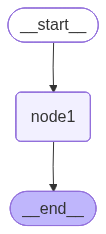

In [6]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

class normalState(TypedDict):
    foo : int

def node1(state):
    print("----NODE 1---")
    return {"foo" : state["foo"] + 1}

builder = StateGraph(normalState)

builder.add_node("node1", node1)

builder.add_edge(START, "node1")
builder.add_edge("node1", END)

normalGraph = builder.compile()

display(Image(normalGraph.get_graph().draw_mermaid_png()))


In [7]:
normalGraph.invoke({"foo": 10 })

----NODE 1---


{'foo': 11}

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


#### BRANCHING

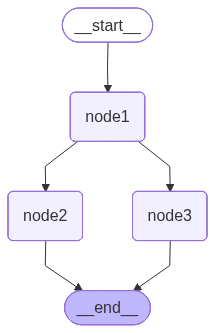

In [11]:
class normalState(TypedDict):
    foo : int

def node1(state):
    print("----NODE 1---")
    return {"foo" : state["foo"] + 1}

def node2(state):
    print("----NODE 2---")
    return {"foo" : state["foo"] + 1}

def node3(state):
    print("----NODE 3---")
    return {"foo" : state["foo"] + 1}

builder = StateGraph(normalState)

builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node1", "node3")
builder.add_edge("node2", END)
builder.add_edge("node3", END)

BranchGraph = builder.compile()

display(Image(BranchGraph.get_graph().draw_mermaid_png()))


In [14]:
from langgraph.errors import InvalidUpdateError
try:
    BranchGraph.invoke({"foo" : 10 })
except InvalidUpdateError as e:
    print(f"InvalidUpdateError: {e} ")

----NODE 1---
----NODE 2---
----NODE 3---
InvalidUpdateError: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_CONCURRENT_GRAPH_UPDATE 


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


### REDUCERS

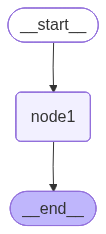

In [21]:
from typing import Annotated
from operator import add


class normalState(TypedDict):
    foo : Annotated[list[int], add]

def node1(state):
    print("----NODE 1---")
    return {"foo" : [state["foo"][0] + 1]}

builder = StateGraph(normalState)

builder.add_node("node1", node1)

builder.add_edge(START, "node1")
builder.add_edge("node1", END)

ReducerGraph = builder.compile()

display(Image(ReducerGraph.get_graph().draw_mermaid_png()))

In [25]:
ReducerGraph.invoke({"foo": [8] })

----NODE 1---


{'foo': [8, 9]}

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


### REDUCERS WITH BRANCHING

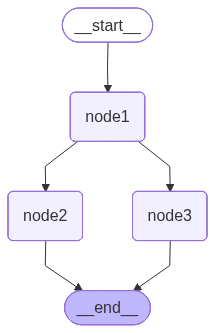

In [29]:
class normalState(TypedDict):
    foo : Annotated[list[int], add]

def node1(state):
    print("----NODE 1---")
    return {"foo" : [state["foo"][-1] + 1]}

def node2(state):
    print("----NODE 2---")
    return {"foo" : [state["foo"][-1] + 1]}

def node3(state):
    print("----NODE 3---")
    return {"foo" : [state["foo"][-1] + 1]}

builder = StateGraph(normalState)

builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node1", "node3")
builder.add_edge("node2", END)
builder.add_edge("node3", END)

BranchRedGraph = builder.compile()

display(Image(BranchRedGraph.get_graph().draw_mermaid_png()))


In [30]:
BranchRedGraph.invoke({"foo" : [5] })

----NODE 1---
----NODE 2---
----NODE 3---


{'foo': [5, 6, 7, 7]}

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [32]:
try:
    BranchRedGraph.invoke({"foo" : None })
except TypeError as e:
    print(f"TypeError: {e} ")


TypeError: can only concatenate list (not "NoneType") to list 


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


### Custom Reducer

In [43]:
def custom_reducer(left : list | None, right : list| None) -> list:
    """ Custom reducer that merges two lists by concatenation.
    Returns a new list that is the concatenation of left and right.
    If either left or right is None, it treats it as an empty list.
    Args:
        left (list | None): The left list to merge.
        right (list | None): The right list to merge.
    Returns:
        list: The concatenated list.    
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

In [46]:
from typing import Annotated
from operator import add
from typing_extensions import TypedDict

class myNormalState(TypedDict):
    foo : Annotated[list[int], add]
    
class customState(TypedDict):
    foo : Annotated[list[int], custom_reducer]

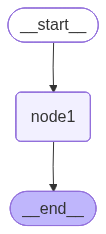

TypeError: can only concatenate list (not "NoneType") to list 


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [59]:
#Building a graph with normalState

def node1(state):
    print("----NODE 1---")
    return {"foo" : [2]}

builder = StateGraph(myNormalState)

builder.add_node("node1", node1)

builder.add_edge(START, "node1")
builder.add_edge("node1", END)

myNormalGraph = builder.compile()

display(Image(myNormalGraph.get_graph().draw_mermaid_png()))

try:
    print(myNormalGraph.invoke({"foo" : None }))
except TypeError as e:
    print(f"TypeError: {e} ")

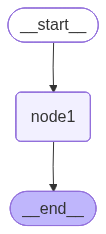

----NODE 1---
{'foo': [2]}


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [60]:
#Building a graph with customState

def node1(state):
    print("----NODE 1---")
    return {"foo" : [2]}

builder = StateGraph(customState)

builder.add_node("node1", node1)

builder.add_edge(START, "node1")
builder.add_edge("node1", END)

customGraph = builder.compile()

display(Image(customGraph.get_graph().draw_mermaid_png()))

try:
    print(customGraph.invoke({"foo" : None }))
except TypeError as e:
    print(f"TypeError: {e} ")

### Messages

In [63]:
# We will learn to add messages
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages, AnyMessage
from langchain_core.messages import AIMessage, HumanMessage


class customMesState(TypedDict):
    msg : Annotated[list[AnyMessage], add_messages]
    addVar1 : str
    addVar2 : str

class messageState(MessagesState):
    addVar1 : str
    addVar2 : str



In [65]:
initMsg = [AIMessage(content="Hello there! How may I help you today?"),
           HumanMessage(content = "I wanna know about the consequences of being apolitical")]
newMsg =  [AIMessage(content="The consequences of being apolitical are that you lose the rights to complain")]

add_messages(initMsg, newMsg)

[AIMessage(content='Hello there! How may I help you today?', additional_kwargs={}, response_metadata={}, id='79899c1b-a8f6-4c5a-af4d-188d36a22c06', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I wanna know about the consequences of being apolitical', additional_kwargs={}, response_metadata={}, id='8df491fd-5448-4aee-9595-427e64df3fe4'),
 AIMessage(content='The consequences of being apolitical are that you lose the rights to complain', additional_kwargs={}, response_metadata={}, id='0bf07e39-bed2-4b74-91a3-5cc4dbed1c5d', tool_calls=[], invalid_tool_calls=[])]

In [66]:
#With IDs

initMsg = [AIMessage(content="Hello there! How may I help you today?", id = 1),
           HumanMessage(content = "I wanna know about the consequences of being apolitical", id = 2)]
newMsg =  [HumanMessage(content="The consequences of being apolitical are that you lose the rights to complain", id = 2)]

add_messages(initMsg, newMsg)

[AIMessage(content='Hello there! How may I help you today?', additional_kwargs={}, response_metadata={}, id='1', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='The consequences of being apolitical are that you lose the rights to complain', additional_kwargs={}, response_metadata={}, id='2')]

In [69]:
from langchain_core.messages import RemoveMessage

messages = [AIMessage(content="Hi! How may I help you?")]
messages.append(HumanMessage("I wanna know about Kim K"))
messages.append(AIMessage("She is a successful enterprenuer"))
messages.append(HumanMessage("And her sister?"))

delete_msg = [RemoveMessage(id = m.id) for m in messages[:-2]]
print(delete_msg)


[RemoveMessage(content='', additional_kwargs={}, response_metadata={}), RemoveMessage(content='', additional_kwargs={}, response_metadata={})]


In [70]:
add_messages(delete_msg, messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='6b88b312-31a3-4d56-8485-6ccd170500fe'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='221fde79-6fb4-4c1a-805a-980a84d20601'),
 AIMessage(content='Hi! How may I help you?', additional_kwargs={}, response_metadata={}, id='eff671dc-f162-4080-b435-f7b3ecbbd874', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I wanna know about Kim K', additional_kwargs={}, response_metadata={}, id='4e85891e-43d4-4530-9537-540a46a55746'),
 AIMessage(content='She is a successful enterprenuer', additional_kwargs={}, response_metadata={}, id='89bdb418-7f3d-4eb0-8cbf-6e5f5b4cc69e', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='And her sister?', additional_kwargs={}, response_metadata={}, id='ba93596e-ca3f-4d8d-80eb-c6383149938e')]